In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# Veri dizinleri
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 64

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])

# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# EfficientNetB0 için ön işleme fonksiyonu
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.


In [2]:
from tensorflow.keras.applications import EfficientNetB0

# EfficientNetB0 modelini yükle
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb0_model.keras', save_best_only=True, monitor='val_accuracy')
epochs = 100

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 281s 948ms/step - accuracy: 0.7292 - loss: 0.8118 - val_accuracy: 0.8652 - val_loss: 0.3966
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 237s 862ms/step - accuracy: 0.8475 - loss: 0.4393 - val_accuracy: 0.8652 - val_loss: 0.3651
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 237s 863ms/step - accuracy: 0.8549 - loss: 0.4100 - val_accuracy: 0.8679 - val_loss: 0.3540
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 237s 861ms/step - accuracy: 0.8554 - loss: 0.3996 - val_accuracy: 0.8718 - val_loss: 0.3472
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 237s 861ms/step - accuracy: 0.8594 - loss: 0.3874 - val_accuracy: 0.8673 - val_loss: 0.3472
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 237s 861ms/step - accuracy: 0.8604 - loss: 0.3797 - val_accuracy: 0.8702 - val_loss: 0.3390
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 237s 861ms/step - accuracy: 0.8583 - loss: 0.3763 - val_accuracy: 0.8679 - val_loss: 0.3416
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 237s 863ms/step - accuracy: 

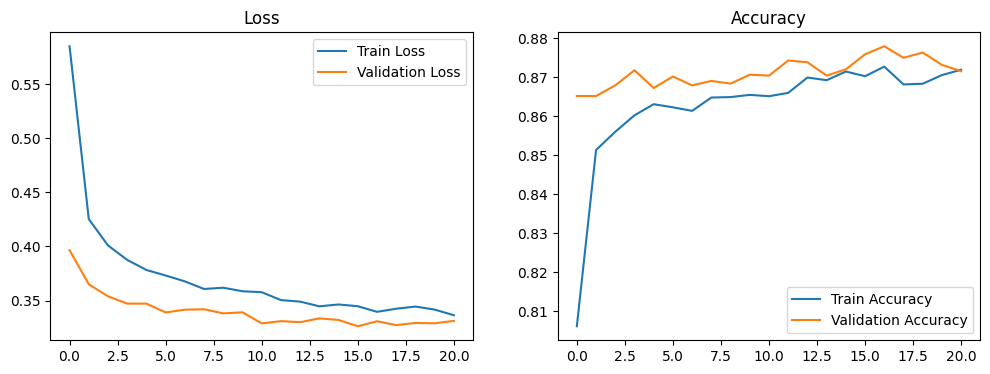

In [5]:
# Eğitim ve doğrulama kaybını ve doğruluğunu çiz
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()